In [16]:
import sys
import os

# 获取当前文件所在目录的绝对路径
current_dir = os.path.dirname(os.path.abspath('.'))
# 获取项目根目录
project_root = os.path.join(current_dir, '..')
# 将项目根目录添加到 sys.path
sys.path.append(project_root)


# 从根目录导入自定义库
from evals.eval4_end_to_end.utils.contract import Contract
C = Contract()

# 系统库
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

In [17]:
# 目的：评估使用不同的MO效用函数，分别设计trainer和verifier的合约
# 是否会导致worker仅偏向于选择其中一种

DEBUG = False

# 输入参数
participants_num = 100
estimated_types = np.array([0.1, 0.13, 0.16, 0.19, 0.22])
estimated_props = np.array([0.1, 0.2, 0.25, 0.25, 0.2])
participants = [(10, 0.11), (20, 0.12), (20, 0.15), (20, 0.20), (20, 0.21)]

u_p = lambda reward, cost: reward - cost

# k1为全局准确率到模型价值的转换参数
# k2和k3为本地训练数据总量到全局模型准确率的转换参数（和训练任务有关，需要根据实际任务调整）
u_m_k = []
u_m = lambda data, reward: u_m_k[0] * cp.log(1 + u_m_k[1] * data) - reward

def plot_results(contracts, estimated_utilities):
    # A 折线图
    fig, ax1 = plt.subplots()

    contract_nums = range(1, len(contracts) + 1)
    gradient_quality = [contract[0] for contract in contracts]
    rewards = [contract[1] for contract in contracts]

    ax1.set_xlabel("Model Owner Type m")
    ax1.set_ylabel("Data size", color="tab:blue")
    ax1.plot(
        contract_nums,
        gradient_quality,
        "o-",
        color="tab:blue",
        label="Gradient Quality",
    )
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    plt.grid(ls="--", alpha=0.2)

    ax2 = ax1.twinx()
    ax2.set_ylabel("Rewards", color="tab:red")
    ax2.plot(contract_nums, rewards, "v--", color="tab:red", label="Rewards")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    fig.tight_layout()
    plt.title("Data size and Rewards vs. Model Owner Type")
    fig.legend(loc="upper left", bbox_to_anchor=(0.12, 0.96))
    plt.show()

    # B 折线图
    plt.figure()
    for eta, utilities in estimated_utilities.items():
        plt.plot(contract_nums, utilities, "o-", label=f"Type η = {eta}")
    plt.xlabel("Contract Items")
    plt.ylabel("Utility")
    plt.title("Utility vs. Contract Items for Different Types")
    plt.legend()
    plt.grid(ls="--", alpha=0.2)
    plt.show()

best [225, 0.001]
设计的合约项: [(array(19.99999999), 4.399999998257787), (array(159.9999996), 30.999999924150753), (array(384.99999721), 66.99999954134563), (array(695.99999897), 107.42999976966544), (array(1196.99999959), 157.52999983257467)]
选择的合约项: [(0.11, 10, (array(695.99999897), 107.42999976966544)), (0.12, 20, (array(695.99999897), 107.42999976966544)), (0.15, 20, (array(384.99999721), 66.99999954134563)), (0.2, 20, (array(19.99999999), 4.399999998257787)), (0.21, 20, (array(19.99999999), 4.399999998257787))]
各参与者的实际效用: [30.869999883425464, 23.909999893767278, 9.249999959918867, 0.3999999998416168, 0.1999999999208084]
所有参与者的总效用: 983.8999959032259
模型拥有者的实际效用: 470.8139041884004


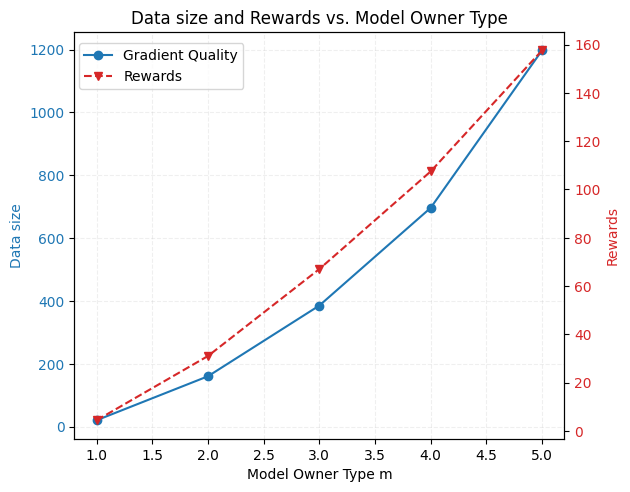

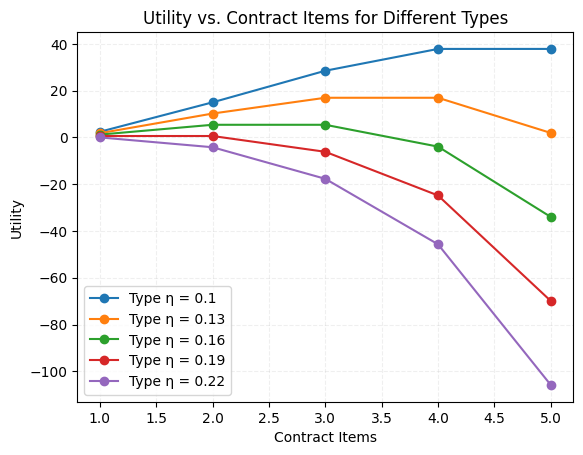

best [300, 0.001]
设计的合约项: [(array(391.99999884), 86.23999974425531), (array(538.99999955), 114.16999987893385), (array(897.99999547), 171.60999922663638), (array(1263.99999825), 219.18999958755836), (array(2025.99999155), 295.38999891811613)]
选择的合约项: [(0.11, 10, (array(1263.99999825), 219.18999958755836)), (0.12, 20, (array(1263.99999825), 219.18999958755836)), (0.15, 20, (array(897.99999547), 171.60999922663638)), (0.2, 20, (array(391.99999884), 86.23999974425531)), (0.21, 20, (array(391.99999884), 86.23999974425531))]
选择的合约项2: [(0.11, 10, (array(695.99999897), 107.42999976966544)), (0.12, 20, (array(695.99999897), 107.42999976966544)), (0.15, 20, (array(384.99999721), 66.99999954134563)), (0.2, 20, (array(19.99999999), 4.399999998257787)), (0.21, 20, (array(19.99999999), 4.399999998257787))]
各参与者的实际效用: [80.14999978051787, 67.50999979805965, 36.90999990621145, 7.839999976750477, 3.9199999883752383]
所有参与者的总效用: 3125.0999911931153
模型拥有者的实际效用: 1710.4013938953053


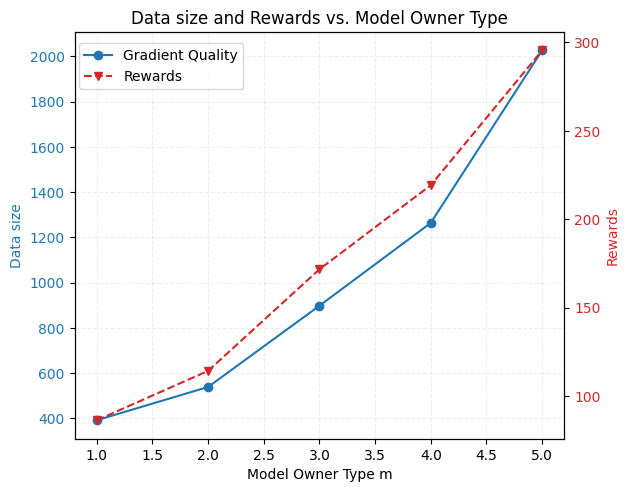

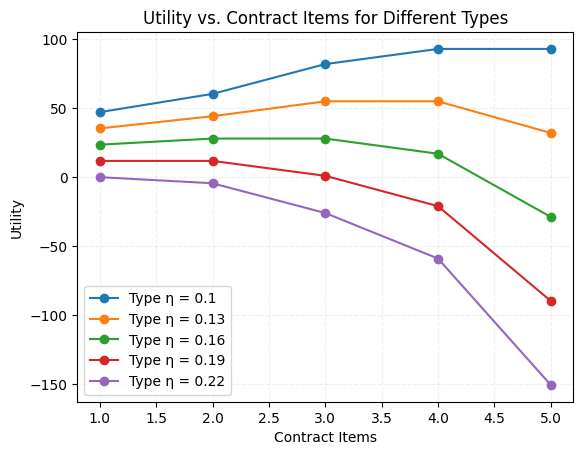

In [18]:
# 【实验1】激励机制正确性（优化得到的合约满足IR和IC）
# TODO：该实验仅测一组参数是否合理？考虑测两组（即后续实验使用的两个典型任务）？


# method 可选：best/uniform/baseline
def run_test1(method, contracts2=None):
    # baseline方法使用用户的实际类型来设计合约
    if method == "baseline":
        contracts = C.design_contract([cost for num, cost in participants], u_m, u_p)
    else:
        contracts = C.design_contract(estimated_types, u_m, u_p)

    if contracts:
        print("设计的合约项:", contracts)
    else:
        print("错误：合约设计失败")
        return

    # baseline 和 best 方案 合约选择方法都用best
    selections = C.select_contract(
        participants, contracts, "uniform" if method == "uniform" else "best"
    )
    print("选择的合约项:", selections)

    if contracts2 is not None:
        selections2 = C.select_contract(
            participants, contracts2, "uniform" if method == "uniform" else "best"
        )
        print("选择的合约项2:", selections2)

    # 模拟攻击者有[attacker_rate]概率骗过雇主，不付出任何贡献就能拿到合约奖励
    # 因此模型拥有者拿到的贡献减少了
    (
        participant_utilities_all,
        participant_utilities,
        model_owner_utility,
        estimated_utilities,
    ) = C.evaluate_effect(selections, estimated_types, contracts)
    print("各参与者的实际效用:", participant_utilities)
    print("所有参与者的总效用:", sum(participant_utilities_all))
    print("模型拥有者的实际效用:", model_owner_utility)

    if DEBUG:
        print("每个类型选择各合约项时的效用:")
        for eta, utilities in estimated_utilities.items():
            print(f"类型 {eta}: {utilities}")
    plot_results(contracts, estimated_utilities)

    return contracts


def eval1():
    global u_m_k
    # 设定实验参数
    u_m_k = [225, 0.001]
    print("best", u_m_k)
    contracts = run_test1("best")

    u_m_k = [300, 0.001]
    print("best", u_m_k)
    run_test1("best", contracts)


eval1()